# Variational quantum eigensolver

Usage estimate:

## Background

*Variational quantum algorithms* are promising candidate hybrid-algorithms for observing quantum computation utility on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combinaton of Pauli terms, woth an ansatz circuit where the number of parameters to optiize over is polynomial in the number of qubits, successful minimization using VQE requires, in general, additional problem-specific information to define the structure of the structure of the ansatz circuit.

Executing a VQE algorithm requires the following components:

1. Hamiltonianand ansatz (problem specification)
2. Qiskit Runtime estimator
3. Classical optimizer

Although the Hamiltonian and ansatz require domain-specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner.

## Requirements

Before starting this tutorial, ensure that you have the following installed:
1. Qiskit SDK 1.0 or later, with visualization support (pip install 'qiskit[visualization]')
2. Qiskit Runtime 0.22 or later (pip install qiskit-ibm-runtime)

## Setup


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator


## Step 1: Map classical inputs to a quantum problem

Although the problem instance in question for the VQE algorithm can come from a variety of domains, the form for execution through Qiskit Rutime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the qiskit.circuit.library.

This example Hamiltonian is derived from a quantum chemistery problem.

In [23]:
# To run on hardware, select the backend with the fewest number of jobs
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

print(f"backend name- {backend.name}")

backend name- ibm_torino


In [24]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

Our choice of ansatz is the *efficient_su2* that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.

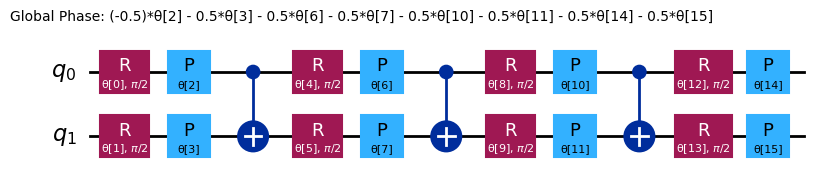

In [25]:
ansatz = efficient_su2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

from the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta$<sub>i</sub> , with the total number given by:

In [26]:
num_params = ansatz.num_parameters
num_params

16

## Step 2: Optimize problem for quantum hardware execution

To reduce the total job execution time, Qiskit primitives only accept circuits(ansatz) and observables (Hamiltonian) that conform to the instructions and connectivity supported by the targey QPU (referred to as instruction set architecture (ISA) circuits and observables).

### ISA circuit

Schedule a series of *qiskit.transpiler* passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA. This can be easily done woth a preset pass manager from *qiskit.transpiler* and its *optimization_level* parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-dqubit operatios. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


In [27]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

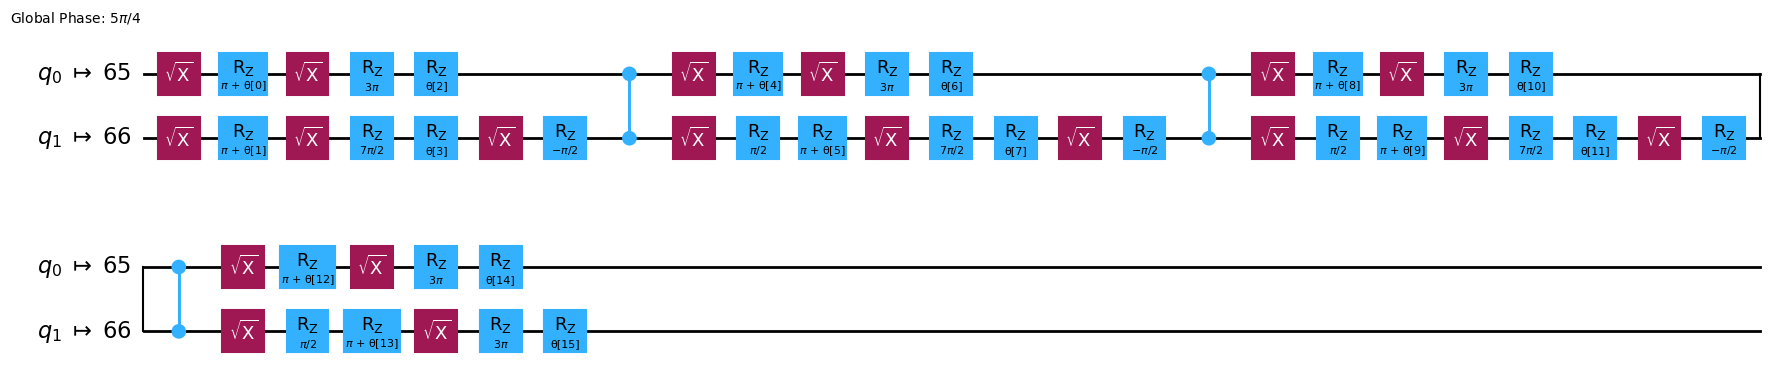

In [28]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA observable

Transform the Hamiltonian to meke it backend-compatible before running jobs with *Runtime Estimator V2* . Perform the transformation by using the *apply_layout* method of *SparsePauliOp* object.

In [29]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit primitives

Like many classical optimazation problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function. By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian. With the Qiskit Runtime *Estimator* directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.
 
 Note that the *run()* method of Qiskit Runtime EstimatorV2 takes an iterable of primitive unified blocs (PUBs). Each PUB is an iterable in the format (circuit, observables, parameter_values: Optiona precision: Optional).


In [30]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """ Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian 
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate      
    """

    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["items"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(
        f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]"
    )
    return energy



Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function. We also access a global variable called *cost_history_dict* within this function. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.

In [31]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the *COBYLA routinefrom SciPy through the minimize function*. Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, specifu a random initial set of parameters:

In [32]:
x0 = 2 * np.pi * np.random.random(num_params)

In [33]:
x0

array([2.61446933, 5.23426257, 4.58857045, 3.13232402, 4.48359686,
       3.40905629, 0.64714656, 2.49856707, 4.26080167, 5.74493978,
       3.51259663, 3.70035543, 3.80715441, 5.18502078, 1.12610908,
       6.00802416])

Because we are sending a large number of jobs that we would like to execute iterativelu, we use a Session to execute all the generated circuits in one block.
Here args is the standard SciPy way to supply the additional parameters needed by the cost function

In [ ]:
estimator = Estimator(backend=backend, mode="direct")
estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
)

RequestsApiError: '400 Client Error: Bad Request for url: https://us-east.quantum-computing.cloud.ibm.com/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different execution mode <https://quantum.cloud.ibm.com/docs/guides/execution-modes>.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"1f4d9381-eb27-45e1-be1b-1a06e19ffd80"}\n'